In [1]:
from skimage import io, morphology, color, util, filters, draw
from scipy import stats
import numpy as np
from PIL import Image
import pandas as pd
import sknw
import os

from math import pi

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", palette="Set2", context="talk")
from IPython.display import display
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

data = "data/"
overview_file = "image_overview.csv"

figs = "figs/"

if not os.path.exists(figs):
    os.mkdir(figs)

In [2]:
def calculate_radius(p1, p2, p3):
    # from https://stackoverflow.com/questions/28910718/give-3-points-and-a-plot-circle/50974391#50974391
    temp = p2[0] * p2[0] + p2[1] * p2[1]
    bc = (p1[0] * p1[0] + p1[1] * p1[1] - temp) / 2
    cd = (temp - p3[0] * p3[0] - p3[1] * p3[1]) / 2
    det = (p1[0] - p2[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p2[1])

    if abs(det) < 1.0e-6:
        return None

    # Center of circle
    cx = (bc*(p2[1] - p3[1]) - cd*(p1[1] - p2[1])) / det
    cy = ((p1[0] - p2[0]) * cd - (p2[0] - p3[0]) * bc) / det

    radius = np.sqrt((cx - p1[0])**2 + (cy - p1[1])**2)
    return radius

def calculate_curvatures(points, dist=10):
    
    curvatures_all = list()
    
    for i in range(len(ps)):

        cur_curvatures = list()
        cur_line = ps[i]

        for i in range(dist, len(cur_line[:,0])-dist):

            xm1, x, xp1 = cur_line[i-dist,0], cur_line[i,0], cur_line[i+dist,0]
            ym1, y, yp1 = cur_line[i-dist,1], cur_line[i,1], cur_line[i+dist,1]

            r = calculate_radius((xm1, ym1), (x,y), (xp1, yp1))
            if r is not None:
                cur_curvatures.append(1/r)
                
        curvatures_all.extend(cur_curvatures)
    
    if len(curvatures_all) != 0:
        return curvatures_all
    else:
        return None
    
def calculate_angles(graph, n_points = 10, n_min = 10):

    nodes = graph.nodes()
    angles = list()

    for i in nodes:

        if len(graph.edges(i)) != 3:
            continue

        neighbors_idx = [j for j in graph.neighbors(i)]
        neighbors_pts = np.array([graph[i][j]['pts'] for j in neighbors_idx])
        neighbors_len = [len(j) for j in neighbors_pts]

        if sum(np.array(neighbors_len) > n_min) != 3:
            continue

        c = graph.nodes(data=True)[i]["o"]

        # find closest n points
        p = [0, 0, 0]
        for i in range(3):
            p[i] = neighbors_pts[i][np.argsort(np.sum((neighbors_pts[i] - c)**2, axis=1))[:n_points],:]

        # linear regression through all sets
        sets = [[0,1], [1,2], [0,2]]
        r_vals = list()
        for i in range(3):
            a, b = sets[i][0], sets[i][1]
            temp_data = np.concatenate((p[a], p[b]), axis=0)

            _, _, r_value, _, _ = stats.linregress(temp_data)
            r_squared = r_value**2

            r_vals.append(r_squared)

        best_idx = sets[np.argmax(r_vals)]
        last_idx = list(set([0,1,2]).difference(set(best_idx)))[0]

        # create two lines, one through two best sets and one through last set. 
        temp_data = np.concatenate((p[best_idx[0]], p[best_idx[1]]), axis=0)
        slope1, _, _, _, _ = stats.linregress(temp_data)
        slope2, _, _, _, _ = stats.linregress(p[last_idx][:,0], p[last_idx][:,1])
        
        if np.isnan(slope1): slope1=1000
        if np.isnan(slope2): slope2=1000

        alpha, beta = np.arctan(slope1)*180/3.14, np.arctan(slope2)*180/3.14
        angle = alpha - beta
        #angle = (m1 - m2)*180/3.14
        if angle < 0:
            angle = -angle
        #if angle > 90:
        #    angle = 180 - angle
        if np.isnan(angle):
            angle = 90

        angles.append(angle)
        
    return angles

def space_filling(img):
    
    convex_hull = morphology.convex_hull_image(img)
    
    return np.sum(img)/np.sum(convex_hull)

In [3]:
img_overview = pd.read_csv(data+overview_file)
img_overview.head(10)

,img_index,input_img_fname,target_img_fname,binary_threshold,segmentation_fname,gene
0,0,0_brightfield.jpg,0_fluorescence.jpg,15,0_target.png,wt
1,1,1_brightfield.jpg,1_fluorescence.jpg,25,1_target.png,wt
2,2,2_brightfield.jpg,2_fluorescence.jpg,15,2_target.png,wt
3,3,3_brightfield.jpg,3_fluorescence.jpg,25,3_target.png,wt
4,4,4_brightfield.jpg,4_fluorescence.jpg,15,4_target.png,wt
5,5,5_brightfield.jpg,5_fluorescence.jpg,25,5_target.png,wt
6,6,6_brightfield.jpg,6_fluorescence.jpg,15,6_target.png,wt
7,9,9_brightfield_chsC.jpg,9_fluorescence_chsC.jpg,20,9_target.png,chsc
8,10,10a_brightfield_chsC.png,10a_fluorescence_chsC.png,25,10a_target.jpg,chsc
9,11,10b_brightfield_chsC.png,10b_fluorescence_chsC.png,25,10b_target.jpg,chsc


In [4]:
branching_freqs = list()
curvatures_all = list()
angles_all = list()
internodal_all = list()
space_filling_all = list()

pixels_per_hyphal_element = 50

n_hours = 24

for idx in range(len(img_overview)):

    fl_fname = img_overview.at[idx, "target_img_fname"]
    fl_img  = io.imread(data + fl_fname)
    fl_img = fl_img[:,:,2]
    fl_img = util.img_as_ubyte(fl_img)
    
    
    threshold = img_overview.at[idx, "binary_threshold"]

    bin_img = fl_img.copy()
    bin_img[bin_img >= threshold] = 255
    bin_img[bin_img < threshold] = 0

    bin_img = bin_img.astype(np.bool)

    bin_img = morphology.remove_small_objects(bin_img, min_size=10000, connectivity=2)

    bin_img = filters.median(bin_img, selem=morphology.square(5))

    ske_img = morphology.skeletonize(bin_img)
    ske_img = morphology.remove_small_objects(ske_img, min_size=1000, connectivity=2)
    
    # build graph from skeleton
    graph = sknw.build_sknw(ske_img)

    # draw node by o
    nodes = graph.nodes()
    bs = np.array([nodes[i]['o'] for i in nodes if len(graph.edges(i))>=3])
    ts = np.array([nodes[i]['o'] for i in nodes if len(graph.edges(i))<=2])
    
    ps = list()
    internodal_lengths = list()

    for (s,e) in graph.edges():
        ps.append(graph[s][e]['pts'].astype(np.int32))
        
        if len([j for j in graph.neighbors(s)]) == 3 and len([j for j in graph.neighbors(e)]) == 3:
            internodal_lengths.append(len(graph[s][e]['pts'].astype(np.int32)))
        
    internodal_all.append(internodal_lengths)
    branch_occurence = (len(bs))/graph.size(weight="weight")    
    branching_freqs.append(branch_occurence*pixels_per_hyphal_element/24)    
    
    curvatures = calculate_curvatures(ps)
    curvatures_all.append(curvatures)
        
    angles = calculate_angles(graph)
    angles_all.append(angles)
    
    space_filling_all.append(space_filling(ske_img))
 

# Statistics per image/strain

In [5]:
strain_stats = img_overview.loc[:, ["gene"]].copy()

strain_stats["branching_frequency"] = branching_freqs
strain_stats["space_fillingness"] = space_filling_all
strain_stats["curvature"] = curvatures_all
strain_stats["angle"] = angles_all
strain_stats["internodal_length"] = internodal_all
strain_stats.head(10)

,gene,branching_frequency,space_fillingness,curvature,angle,internodal_length
0,wt,0.015759,0.006635,"[0.0075730958986211525, 0.0075730958986211525,...","[51.70344288049212, 90.74721690685989, 96.7611...","[279, 334, 46, 68, 65, 365, 82, 42, 85, 4, 91,..."
1,wt,0.013036,0.007742,"[0.031228050490911898, 0.02483455621622304, 0....","[87.48090302233821, 88.70861128352912, 58.8440...","[420, 54, 6, 70, 39, 55, 232, 29, 226, 81, 153..."
2,wt,0.014245,0.005726,"[0.017440987965908723, 0.008393915280506137, 0...","[102.90021534501929, 102.38589338418811, 98.04...","[30, 3, 20, 11, 43, 190, 317, 10, 3, 11, 3, 3,..."
3,wt,0.018739,0.012152,"[0.017440987965908726, 0.03409816821835206, 0....","[85.06121041853595, 99.9565419066177, 73.77898...","[259, 195, 28, 197, 359, 426, 387, 232, 12, 28..."
4,wt,0.021226,0.013627,"[0.033648295041581386, 0.02246963455025197, 0....","[95.24475718411489, 80.03441271512409, 84.0150...","[141, 112, 139, 18, 66, 65, 53, 33, 23, 118, 3..."
5,wt,0.018071,0.011933,"[0.00839391528050614, 0.00839391528050614, 0.0...","[81.13252807025474, 63.79511871324702, 51.1796...","[26, 13, 42, 233, 175, 185, 55, 99, 352, 144, ..."
6,wt,0.019359,0.010139,"[0.017246506858208475, 0.004016339575624078, 0...","[85.62038501913656, 79.90739973177233, 87.1023...","[274, 243, 125, 178, 84, 16, 35, 47, 75, 40, 7..."
7,chsc,0.024396,0.016236,"[0.03641785203646149, 0.03641785203646149, 0.0...","[68.46937680683112, 94.37708167609264, 40.6307...","[77, 125, 157, 156, 32, 117, 99, 63, 18, 64, 1..."
8,chsc,0.028973,0.021730,"[0.026888532719620644, 0.01869129492474109, 0....","[88.82162217165173, 77.09184130445527, 84.5908...","[37, 35, 78, 45, 14, 39, 24, 18, 23, 31, 37, 2..."
9,chsc,0.022213,0.013664,"[0.014242182297397127, 0.014242182297397127, 0...","[86.63622539985259, 39.48559625264757, 65.6219...","[36, 8, 68, 43, 62, 44, 19, 43, 43, 77, 52, 9,..."


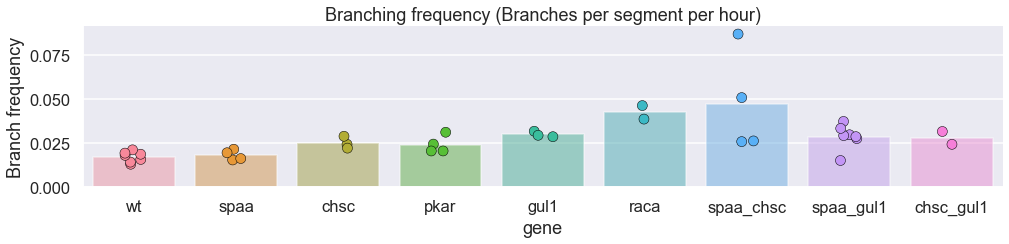

In [6]:
gene_order = ["wt", "spaa", "chsc", "pkar", "gul1", "raca", "spaa_chsc", "spaa_gul1", "chsc_gul1"]

sns.catplot(data=strain_stats, x="gene", y="branching_frequency", 
            alpha=0.5, ci=False, aspect=4, kind="bar", legend_out=True, height=3.5,
            order = gene_order)
ax = sns.stripplot(data=strain_stats, x="gene", hue="gene", 
                   y="branching_frequency", edgecolor="k", linewidth=0.5, size=10,
                   order = gene_order, hue_order = gene_order)

ax.legend_.remove()
plt.title("Branching frequency (Branches per segment per hour)")
plt.ylabel("Branch frequency")
plt.tight_layout()

plt.savefig(figs+"branching.jpg", dpi=600)

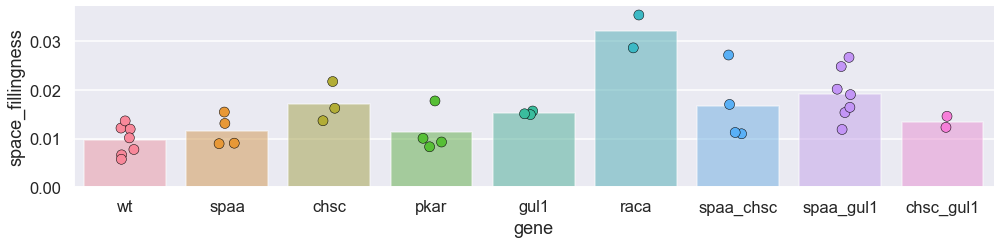

In [7]:
sns.catplot(data=strain_stats, x="gene", y="space_fillingness", 
            alpha=0.5, ci=False, aspect=4, kind="bar", legend_out=True, height=3.5,
            order = gene_order)
ax = sns.stripplot(data=strain_stats, x="gene", hue="gene", 
                   y="space_fillingness", edgecolor="k", linewidth=0.5, size=10,
                   order = gene_order, hue_order = gene_order)

ax.legend_.remove()

plt.tight_layout()

plt.savefig(figs+"space.png", dpi=600)

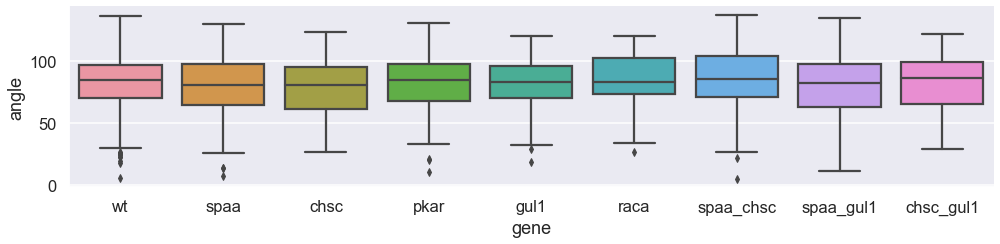

In [8]:
angle_df = strain_stats.loc[:, ["gene", "angle"]].copy()
angle_df = angle_df.explode('angle')

angle_df["angle"] = angle_df["angle"].astype(float)

sns.catplot(data=angle_df, x="gene", y="angle", kind="box", aspect=4, height=3.5, order = gene_order)

#g = sns.FacetGrid(data=angle_df, hue="gene", xlim=(0, 180))
#g.map(sns.boxplot, "angle")

plt.tight_layout()

plt.savefig(figs+"angle.png", dpi=600)

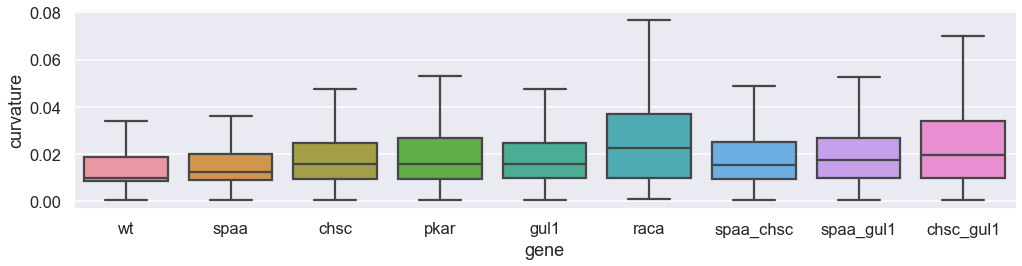

In [9]:
curvature_df = strain_stats.loc[:, ["gene", "curvature"]].copy()
curvature_df = curvature_df.explode('curvature')

curvature_df["curvature"] = curvature_df["curvature"].astype(float)

sns.catplot(data=curvature_df, x="gene", y="curvature", kind="box", showfliers = False, aspect=4, height=3.5,
            order = gene_order)

plt.savefig(figs+"curvature.png", dpi=600)

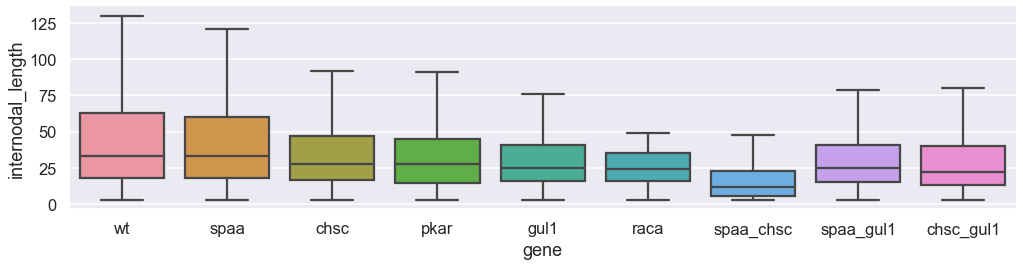

In [10]:
internodal_df = strain_stats.loc[:, ["gene", "internodal_length"]].copy()
internodal_df = internodal_df.explode('internodal_length')

internodal_df["internodal_length"] = internodal_df["internodal_length"].astype(float)

sns.catplot(data=internodal_df, x="gene", y="internodal_length", kind="box", showfliers = False, aspect=4, height=3.5,
            order = gene_order)

plt.savefig(figs+"internodal.png", dpi=600)

In [11]:
strain_stats.loc[:, ["gene", "branching_frequency"]].groupby("gene").agg(['mean', 'std']).reindex(index = gene_order)

branching_frequency          
                         mean       std
gene                                   
wt                   0.017205  0.002948
spaa                 0.018225  0.002855
chsc                 0.025194  0.003450
pkar                 0.024237  0.005033
gul1                 0.030030  0.001610
raca                 0.042606  0.005446
spaa_chsc            0.047613  0.028894
spaa_gul1            0.028798  0.006888
chsc_gul1            0.028034  0.005167

# Create aggregate stats per strain for radar charts

In [39]:
df = strain_stats.loc[:, ["gene", "branching_frequency", "space_fillingness"]] \
     .groupby("gene").mean().reindex(index = gene_order).reset_index()

no_data_append = pd.DataFrame([["apld", np.nan, np.nan]], columns=df.columns)

df = df.append(no_data_append).reset_index(drop=True)

# Import wetlab results and make aggregate stats for radar charts

In [40]:
wet_df = pd.read_csv(data + "wetlab_numerical_data.csv")
wet_df

,sample_index,run,gene,br_1,br_2,bl_1,bl_2,bl_3,bl_4,protein_1,...,lag_1,lag_2,lag_3,lag_4,exp_1,exp_2,exp_3,exp_4,protein_score,our_score
0,1,1,wt,0.4164,0.4233,0.2051,0.2750,0.3471,NaN,2.050491,...,20.504903,21.838555,19.004544,NaN,12.252930,8.835446,9.168859,NaN,NaN,NaN
1,2,1,spaa,0.1909,0.2019,0.3886,0.3896,0.3185,0.2842,0.841014,...,16.010752,16.928034,20.263608,18.595821,7.254872,7.004704,8.088765,7.921987,0.9,0.8
2,3,1,chsc,0.2251,0.2156,0.1964,0.2267,0.2462,0.1765,0.436556,...,26.934754,28.602541,25.934082,23.765960,13.675850,7.921987,7.088093,10.507056,0.5,0.8
3,4,2,wt,0.3665,0.3335,0.2051,0.2750,0.3471,NaN,1.234914,...,20.504903,21.838555,19.004544,NaN,12.252930,8.835446,9.168859,NaN,NaN,NaN
4,5,2,gul1,0.3140,0.3248,0.3340,0.3144,0.3348,0.2753,4.139693,...,13.759240,18.429042,15.677194,18.595821,9.172826,8.422323,8.589101,9.756552,2.9,2.0
5,6,2,raca,0.3590,0.3223,0.1587,0.1586,NaN,NaN,3.393856,...,28.173403,28.756876,14.253408,NaN,20.754967,18.837838,43.927170,NaN,1.4,0.8
6,7,2,spaa_chsc,0.2939,0.2713,0.1540,0.2739,0.3641,NaN,2.559625,...,23.172207,13.669935,12.336283,NaN,20.421550,7.418440,6.168142,NaN,0.7,1.5
7,8,2,spaa_gul1,0.3179,0.3270,0.3073,0.3376,0.3344,NaN,3.922487,...,13.336522,16.587300,16.253886,NaN,11.836164,9.335566,9.085506,NaN,1.8,0.8
8,9,2,chsc_gul1,0.4172,0.4154,0.1670,0.1045,0.1430,NaN,2.603683,...,26.589691,10.252451,25.672805,NaN,13.503229,26.923104,20.171490,NaN,2.0,1.5
9,10,2,pkar,NaN,NaN,0.2061,0.1453,0.2757,NaN,NaN,...,20.504903,14.586821,23.172207,NaN,13.419875,22.005262,10.169098,NaN,NaN,0.5


In [41]:
wet_agg_df = wet_df.loc[:, ["sample_index","run", "gene"]].copy()

wet_agg_df["growth_bioreactor"] = wet_df.loc[:, ["br_1", "br_2"]].mean(axis=1,skipna=True)
wet_agg_df["growth_biolector"] = wet_df.loc[:, ["bl_1", "bl_2", "bl_3", "bl_4"]].mean(axis=1,skipna=True)
wet_agg_df["protein_act"] = wet_df.loc[:, ["protein_1", "protein_2"]].mean(axis=1,skipna=True)
wet_agg_df["lag_duration"] = wet_df.loc[:, ["lag_1", "lag_2", "lag_3", "lag_4"]].mean(axis=1,skipna=True)
wet_agg_df["exp_duration"] = wet_df.loc[:, ["exp_1", "exp_2", "exp_3", "exp_4"]].mean(axis=1,skipna=True)


wet_agg_df

,sample_index,run,gene,growth_bioreactor,growth_biolector,protein_act,lag_duration,exp_duration
0,1,1,wt,0.41985,0.275733,2.319480,20.449334,10.085745
1,2,1,spaa,0.19640,0.345225,1.359566,17.949554,7.567582
2,3,1,chsc,0.22035,0.211450,0.573421,26.309334,9.798246
3,4,2,wt,0.35000,0.275733,1.491828,20.449334,10.085745
4,5,2,gul1,0.31940,0.314625,4.026831,16.615324,8.985200
5,6,2,raca,0.34065,0.158650,2.327339,23.727896,27.839992
6,7,2,spaa_chsc,0.28260,0.264000,2.193356,16.392809,11.336044
7,8,2,spaa_gul1,0.32245,0.326433,3.784072,15.392569,10.085745
8,9,2,chsc_gul1,0.41630,0.138167,2.631749,20.838316,20.199274
9,10,2,pkar,NaN,0.209033,NaN,19.421310,15.198078


In [42]:
run1_genes = list(wet_agg_df.loc[wet_agg_df['run'] == 1, "sample_index"])
run2_genes = list(wet_agg_df.loc[wet_agg_df['run'] == 2, "sample_index"])
num_columns = wet_agg_df.columns[-5:]

# separate datasets
run1_df = wet_agg_df.loc[wet_agg_df["sample_index"].isin(run1_genes)].reset_index(drop=True)
run1_wt = run1_df.loc[run1_df["gene"] == "wt"].reset_index(drop=True)

run2_df = wet_agg_df.loc[wet_agg_df["sample_index"].isin(run2_genes)].reset_index(drop=True)
run2_wt = run2_df.loc[run2_df["gene"] == "wt"].reset_index(drop=True)

# divide by reference
run1_df = run1_df.loc[:, num_columns].div(run1_wt.loc[0, num_columns])
run2_df = run2_df.loc[:, num_columns].div(run2_wt.loc[0, num_columns])

In [43]:
wet_scaled_df = run1_df.append(run2_df).reset_index(drop=True)
wet_scaled_df["gene"] = wet_agg_df["gene"]
wet_scaled_df = wet_scaled_df.loc[wet_scaled_df["gene"] != "wt"].reset_index(drop=True)
wet_scaled_df

,growth_bioreactor,growth_biolector,protein_act,lag_duration,exp_duration,gene
0,0.467786,1.25202,0.586151,0.877757,0.750325,spaa
1,0.52483,0.766864,0.24722,1.28656,0.971495,chsc
2,0.912571,1.14105,2.69926,0.812512,0.890881,gul1
3,0.973286,0.575375,1.56006,1.16033,2.76033,raca
4,0.807429,0.957447,1.47025,0.80163,1.12397,spaa_chsc
5,0.921286,1.18387,2.53653,0.752717,1,spaa_gul1
6,1.18943,0.501088,1.76411,1.01902,2.00275,chsc_gul1
7,NaN,0.7581,NaN,0.949728,1.50689,pkar
8,0,0.38044,NaN,1.62636,3.09917,apld


# Concatenate df's

In [44]:
r_df = df.copy()
num_columns = r_df.columns[-2:]
r_df = r_df.loc[:, num_columns].div(r_df.loc[0, num_columns])

r_df["gene"] = df["gene"]
r_df = r_df[r_df["gene"] != "wt"].reset_index(drop=True)
temp_df = wet_df[wet_df["gene"] != "wt"].reset_index(drop=True).loc[:,["gene", "protein_score", "our_score"]]

r_df = pd.merge(r_df, temp_df, on="gene").reset_index(drop=True)
r_df

,branching_frequency,space_fillingness,gene,protein_score,our_score
0,1.0593,1.19842,spaa,0.9,0.8
1,1.46435,1.77282,chsc,0.5,0.8
2,1.40874,1.16818,pkar,NaN,0.5
3,1.74544,1.56822,gul1,2.9,2.0
4,2.47642,3.30103,raca,1.4,0.8
5,2.7674,1.71084,spaa_chsc,0.7,1.5
6,1.67381,1.9771,spaa_gul1,1.8,0.8
7,1.62945,1.38418,chsc_gul1,2.0,1.5
8,NaN,NaN,apld,0.0,0.0


In [45]:
ms_df = pd.merge(r_df, wet_scaled_df, on="gene").reset_index(drop=True)
df = ms_df[["gene", "our_score", "branching_frequency", "space_fillingness", 
                   "growth_biolector", "growth_bioreactor", "protein_score"]]
#df = df.loc[df["gene"] != "apld"]

# Radar charts

In [91]:
plt.rcParams["axes.axisbelow"] = True
categories=list(df)[1:]
N = len(categories)

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

standard_values=(N+1)*[1]

gene_names = ["ΔspaA", "ΔchsC","ΔpkaR*","Δgul1","ΔracA","ΔspaA, ΔchsC","ΔspaA, Δgul1","ΔchsC, Δgul1", "Δapld"]

true_labels = ["Our score", "Branching\n frequency", "Space\n filling", 
               "Growth rate\n (Biolector)", "Growth rate\n (Bioreactor)", "Protein\n activity"]
#true_labels = ["F", "S", "L", "R", "P"]

alignments = ["center", "left", "left", "center", "right", "right"]
#alignments = ["center"]*N

#colors = sns.color_palette("viridis", 2)
muts_sorted = ['gul1', 'spaa', 'chsc', 'pkar', 'spaa_gul1', 'apld', 'raca','spaa_chsc', 'chsc_gul1', 'wt']
cmap = plt.get_cmap('viridis')
mut_colors = {muts_sorted[idx]:cmap(deci) for idx, deci in enumerate(np.linspace(0, 1, 10))}

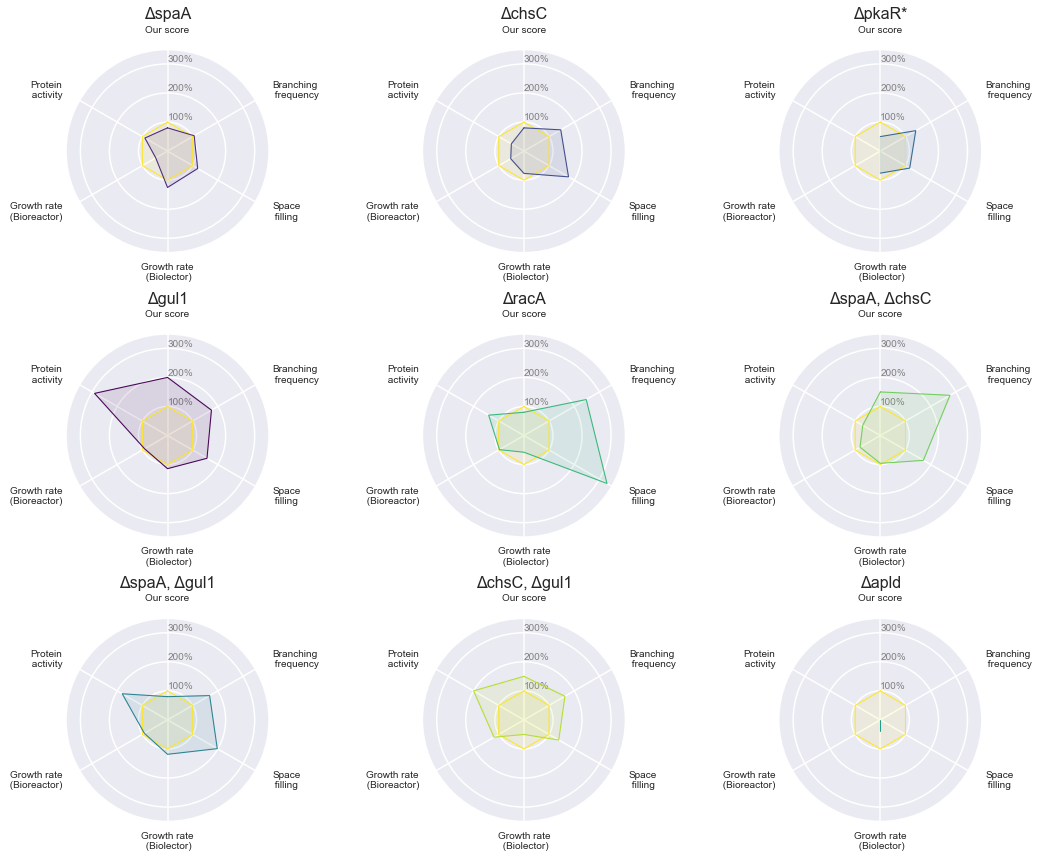

In [92]:
# Initialise the spider plot
f = plt.figure(figsize=[15,12])

for i in range(len(df)):
    
    gene_name = gene_names[i]

    ax = plt.subplot(331 + i, polar=True)


    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, size=10)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([1, 2, 3], ["100%", "200%", "300%"], color="gray", size=10)
    plt.ylim(0,3.5)

    # WT
    ax.plot(angles, standard_values, linewidth=1, linestyle='solid', label="Original strain", color=mut_colors['wt'])
    ax.fill(angles, standard_values, color=mut_colors['wt'], alpha=0.1)

    # Ind2
    values=df.loc[i].drop('gene').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label="Morphological mutant", color=mut_colors[df.at[i, "gene"]])
    ax.fill(angles, values, color=mut_colors[df.at[i, "gene"]], alpha=0.1)


    for i,label in enumerate(ax.get_xticklabels()):
        label.set_ha(alignments[i])

    ax.set_xticklabels(true_labels)
    
    ax.set_title(gene_name, size=16, y=1.12)

# Add legend
#plt.legend(loc='upper right', bbox_to_anchor=(3, 0.5))
#plt.show()
plt.tight_layout()

plt.savefig(figs+"radars11.jpg", dpi=600)

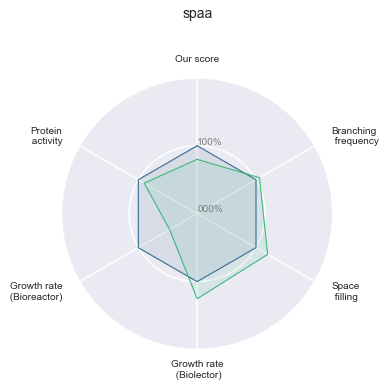

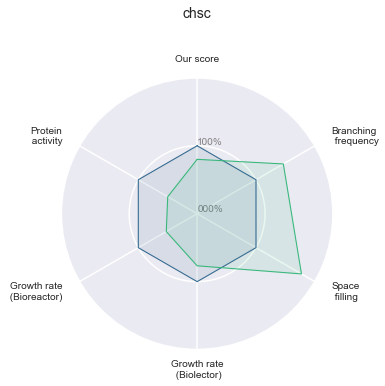

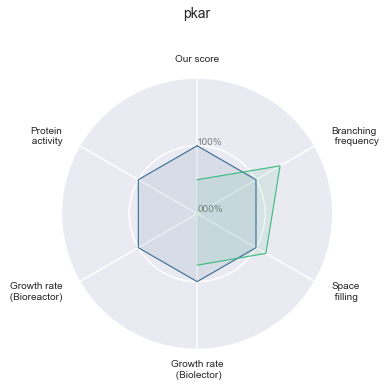

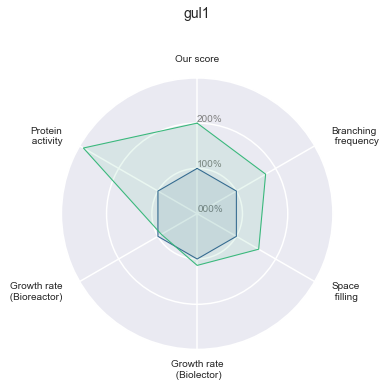

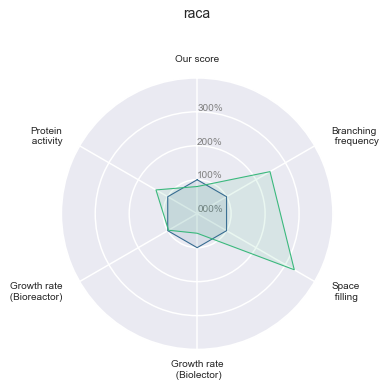

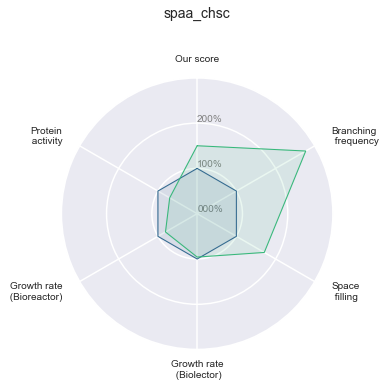

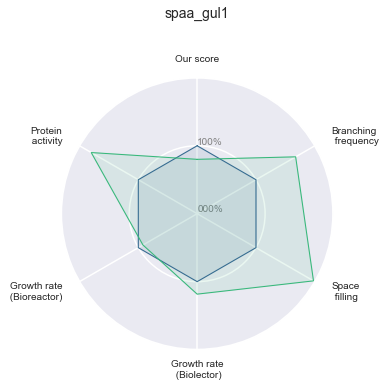

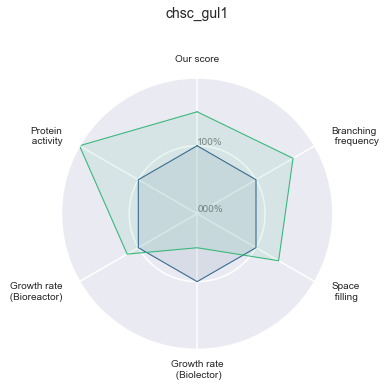

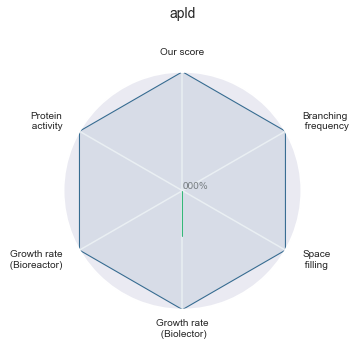

In [68]:
# Initialise the spider plot


for i in range(len(df)):
    
    gene_name = df.at[i, "gene"]
    
    f = plt.figure(figsize=[5,5])
    
    ax = plt.subplot(111, polar=True)


    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, size=10)

    # Draw ylabels
    ax.set_rlabel_position(0)
    
    values=df.loc[i].drop('gene').values.flatten().tolist()
    
    dynamic_ylim = np.ceil(max(values))
    dynamic_yticks = [x for x in range(int(dynamic_ylim))]
    dynamic_yticklabels = [str(x)+"00%" for x in dynamic_yticks]
    
    plt.yticks(dynamic_yticks, dynamic_yticklabels, color="gray", size=10)
    plt.ylim(0,dynamic_ylim)

    # WT
    ax.plot(angles, standard_values, linewidth=1, linestyle='solid', label="Original strain", color=colors[0])
    ax.fill(angles, standard_values, color=colors[0], alpha=0.1)

    # Ind2
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label="Morphological mutant", color=colors[1])
    ax.fill(angles, values, color=colors[1], alpha=0.1)


    for i,label in enumerate(ax.get_xticklabels()):
        label.set_ha(alignments[i])

    ax.set_xticklabels(true_labels)
    
    ax.set_title(gene_name, size=14, y=1.2)
    
    plt.savefig(figs+"radars_" + gene_name + ".jpg", dpi=600)

# Add legend
#plt.legend(loc='upper right', bbox_to_anchor=(3, 0.5))
#plt.show()
plt.tight_layout()

#plt.savefig(figs+"radars2.jpg", dpi=600)

# Wetlab data

In [22]:
wet_df_fixed = wet_df.copy()
wet_df_fixed.at[3, "gene"] = "wt_new"
wet_df_fixed

,sample_index,run,gene,br_1,br_2,bl_1,bl_2,bl_3,bl_4,protein_1,...,lag_1,lag_2,lag_3,lag_4,exp_1,exp_2,exp_3,exp_4,protein_score,our_score
0,1,1,wt,0.4164,0.4233,0.2051,0.2750,0.3471,NaN,2.050491,...,20.504903,21.838555,19.004544,NaN,12.252930,8.835446,9.168859,NaN,NaN,NaN
1,2,1,spaa,0.1909,0.2019,0.3886,0.3896,0.3185,0.2842,0.841014,...,16.010752,16.928034,20.263608,18.595821,7.254872,7.004704,8.088765,7.921987,0.9,0.800000
2,3,1,chsc,0.2251,0.2156,0.1964,0.2267,0.2462,0.1765,0.436556,...,26.934754,28.602541,25.934082,23.765960,13.675850,7.921987,7.088093,10.507056,0.5,0.800000
3,4,2,wt_new,0.3665,0.3335,0.2051,0.2750,0.3471,NaN,1.234914,...,20.504903,21.838555,19.004544,NaN,12.252930,8.835446,9.168859,NaN,NaN,NaN
4,5,2,gul1,0.3140,0.3248,0.3340,0.3144,0.3348,0.2753,4.139693,...,13.759240,18.429042,15.677194,18.595821,9.172826,8.422323,8.589101,9.756552,2.9,2.000000
5,6,2,raca,0.3590,0.3223,0.1587,0.1586,NaN,NaN,3.393856,...,28.173403,28.756876,14.253408,NaN,20.754967,18.837838,43.927170,NaN,1.4,0.800000
6,7,2,spaa_chsc,0.2939,0.2713,0.1540,0.2739,0.3641,NaN,2.559625,...,23.172207,13.669935,12.336283,NaN,20.421550,7.418440,6.168142,NaN,0.7,1.500000
7,8,2,spaa_gul1,0.3179,0.3270,0.3073,0.3376,0.3344,NaN,3.922487,...,13.336522,16.587300,16.253886,NaN,11.836164,9.335566,9.085506,NaN,1.8,0.800000
8,9,2,chsc_gul1,0.4172,0.4154,0.1670,0.1045,0.1430,NaN,2.603683,...,26.589691,10.252451,25.672805,NaN,13.503229,26.923104,20.171490,NaN,2.0,1.500000
9,10,2,pkar,NaN,NaN,0.2061,0.1453,0.2757,NaN,NaN,...,20.504903,14.586821,23.172207,NaN,13.419875,22.005262,10.169098,NaN,NaN,0.500000


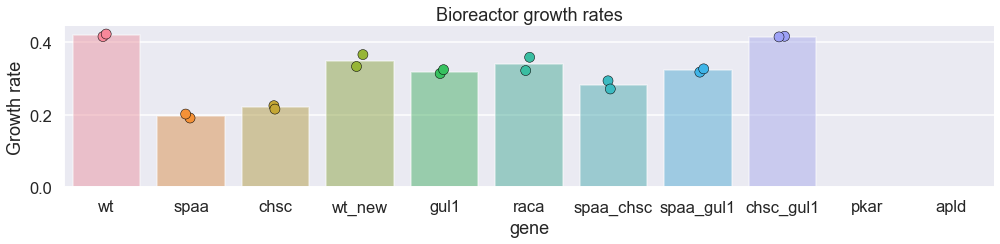

In [23]:
br_df =pd.melt(wet_df_fixed.loc[:, ["run", "gene", "br_1", "br_2"]], 
               id_vars=['run','gene'], value_vars=['br_1', 'br_2'])

sns.catplot(data=br_df, x="gene", y="value", 
            alpha=0.5, ci=False, aspect=4, kind="bar", legend_out=True, height=3.5)
ax = sns.stripplot(data=br_df, x="gene", hue="gene", 
                   y="value", edgecolor="k", linewidth=0.5, size=10)

plt.title("Bioreactor growth rates")
plt.ylabel("Growth rate")

ax.legend_.remove()
plt.tight_layout()

plt.savefig(figs+"br.png", dpi=600)

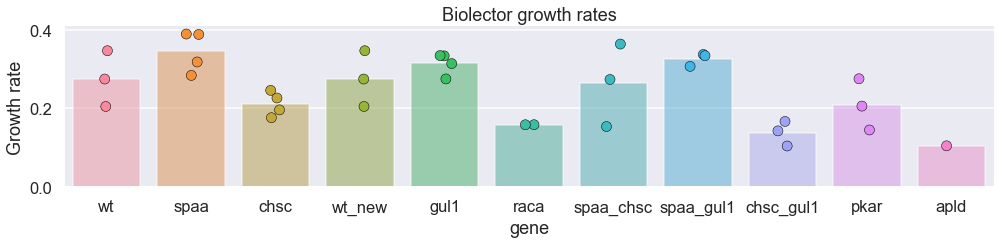

In [24]:
br_df =pd.melt(wet_df_fixed.loc[:, ["run", "gene", "bl_1", "bl_2","bl_3","bl_4"]], 
               id_vars=['run','gene'], value_vars=["bl_1", "bl_2","bl_3","bl_4"])

sns.catplot(data=br_df, x="gene", y="value", 
            alpha=0.5, ci=False, aspect=4, kind="bar", legend_out=True, height=3.5)
ax = sns.stripplot(data=br_df, x="gene", hue="gene", 
                   y="value", edgecolor="k", linewidth=0.5, size=10)

ax.legend_.remove()
plt.title("Biolector growth rates")
plt.ylabel("Growth rate")
plt.tight_layout()

plt.savefig(figs+"bl.png", dpi=600)

In [25]:
br_df =pd.melt(wet_df_fixed.loc[:, ["run", "gene", "lag_1", "lag_2", "lag_3", "lag_4", "exp_1", "exp_2", "exp_3", "exp_4"]], 
               id_vars=['run','gene'], value_vars=["lag_1", "lag_2", "lag_3", "lag_4", "exp_1", "exp_2", "exp_3", "exp_4"])

br_df["phase"] = br_df["variable"].str[0:3]
br_df

,run,gene,variable,value,phase
0,1,wt,lag_1,20.504903,lag
1,1,spaa,lag_1,16.010752,lag
2,1,chsc,lag_1,26.934754,lag
3,2,wt_new,lag_1,20.504903,lag
4,2,gul1,lag_1,13.759240,lag
...,...,...,...,...,...
83,2,spaa_chsc,exp_4,NaN,exp
84,2,spaa_gul1,exp_4,NaN,exp
85,2,chsc_gul1,exp_4,NaN,exp
86,2,pkar,exp_4,NaN,exp


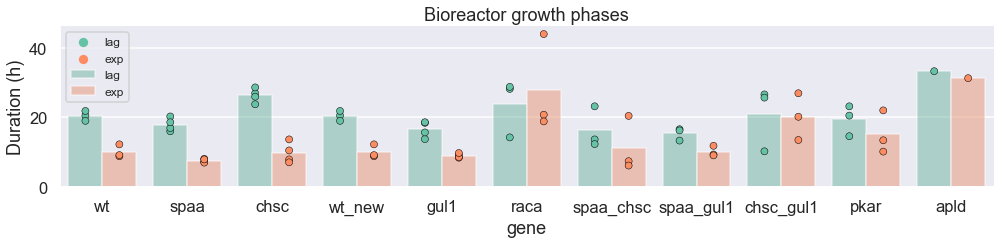

In [26]:
sns.catplot(data=br_df, x="gene", y="value", hue="phase",
            alpha=0.5, ci=False, aspect=4, kind="bar", height=3.5, legend=False)
ax = sns.stripplot(data=br_df, x="gene", hue="phase", 
                   y="value", edgecolor="k", linewidth=0.5, size=7, dodge=True, jitter=False)

ax.legend_.remove()
plt.title("Bioreactor growth phases")
plt.ylabel("Duration (h)")
plt.tight_layout()

plt.legend(prop={'size': 12})


plt.savefig("br.png", dpi=600)

In [27]:
br_df =pd.melt(wet_df_fixed.loc[:, ["run", "gene", "protein_1", "protein_2"]], 
               id_vars=['run','gene'], value_vars=["protein_1", "protein_2"])

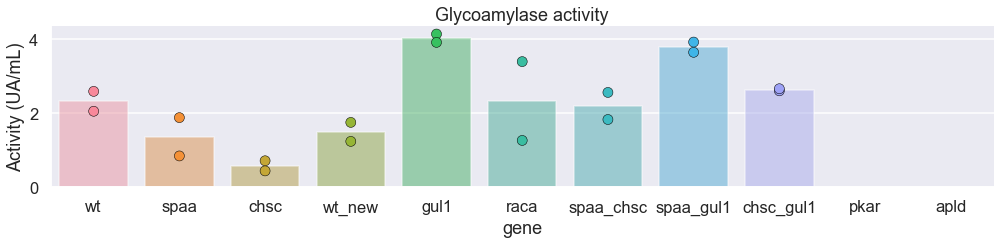

In [28]:
sns.catplot(data=br_df, x="gene", y="value", 
            alpha=0.5, ci=False, aspect=4, kind="bar", legend_out=True, height=3.5)
ax = sns.stripplot(data=br_df, x="gene", hue="gene", 
                   y="value", edgecolor="k", linewidth=0.5, size=10, jitter=False)

ax.legend_.remove()
plt.title("Glycoamylase activity")
plt.ylabel("Activity (UA/mL)")
plt.tight_layout()

plt.savefig("br.png", dpi=600)